In [41]:
!pip install  causalinference

   ---------------------------------------- 0.0/51.1 kB ? eta -:--:--
   ---------------- ----------------------- 20.5/51.1 kB 682.7 kB/s eta 0:00:01
   -------------------------------- ------- 41.0/51.1 kB 495.5 kB/s eta 0:00:01
   ---------------------------------------- 51.1/51.1 kB 524.1 kB/s eta 0:00:00


In [43]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from causalinference import CausalModel
import dowhy
from dowhy import CausalModel
import shap

In [109]:
import pandas as pd

# Load a supply chain dataset (e.g., inventory, lead time, supplier delays)
df = pd.read_csv("soccer_data2425.csv")

In [121]:
df.replace("#REF!", pd.NA, inplace=True)

In [167]:
# Replace '#REF!' and '<NA>' with NaN
df.replace(["#REF!", "<NA>"], pd.NA, inplace=True)

# Convert numeric columns
numeric_cols = ["Duration", "Distance (metres)", "Distance >19,8", "HSR"]  # Add more columns as needed
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')  # Convert, setting errors to NaN

# Fill missing numeric values with the median
df.fillna(df.median(numeric_only=True), inplace=True)


In [137]:
df["Participation"] = df["Participation"].fillna("Absent")
df["Injury"] = df["Injury"].fillna("No Injury")

# Fill "Position" only if it exists
if "Position" in df.columns:
    df["Position"] = df["Position"].fillna(df["Position"].mode()[0])


In [139]:
df.drop(columns=["DAY CODE", "Notes"], inplace=True)

In [141]:
df.to_csv("final_cleaned_soccer_dataset.csv", index=False)


In [143]:
# Examine the shape of the data
print("Shape of the data:", df.shape)

# Check data types
print("\nData types of each column:\n", df.dtypes)

# Descriptive statistics for numerical columns
print("\nDescriptive statistics for numerical columns:\n", df.describe())

# Missing values
print("\nNumber of missing values in each column:\n", df.isnull().sum())

# Unique values for categorical variables
for column in df.columns:
  if df[column].dtype == 'object':
    print(f"\nUnique values for {column}:\n", df[column].unique())
    print(f"Value counts for {column}:\n", df[column].value_counts())

Shape of the data: (5787, 22)

Data types of each column:
 Date                                        object
Name                                        object
Duration                                   float64
Distance (metres)                          float64
Distance >19,8                             float64
Distance >25,2                              object
HSR                                        float64
Distance Power Zone: 25 - 50 w/kg           object
Distance Power Zone: > 50 w/kg (metres)     object
HMLD                                        object
Sprints                                     object
Top Speed (km/h)                            object
Accelerations > 4 m/s/s                     object
Deceleration > 4 m/s/s                      object
Max Acc                                     object
Max Dec                                     object
Participation                               object
group                                       object
Injury<7               

In [145]:
df.head()

,Date,Name,Duration,Distance (metres),"Distance >19,8","Distance >25,2",HSR,Distance Power Zone: 25 - 50 w/kg,Distance Power Zone: > 50 w/kg (metres),HMLD,...,Accelerations > 4 m/s/s,Deceleration > 4 m/s/s,Max Acc,Max Dec,Participation,group,Injury<7,injury>7,Injury,position2
0,22-Jul-24,Abdalla Garib,50.6,4334.0,27.0,0,27.0,106,14,120,...,2,2,4.5,7.3,OK,U21,NaN,NaN,No Injury,SD
1,23-Jul-24,Abdalla Garib,62.5,4334.0,35.0,10,45.0,166,19,185,...,9,5,4.7,6,OK,U21,NaN,NaN,No Injury,SD
2,24-Jul-24,Abdalla Garib,66.0,4334.0,34.0,7,41.0,197,38,235,...,14,12,5,5.8,OK,U21,NaN,NaN,No Injury,SD
3,27-Jul-24,Abdalla Garib,66.6,4334.0,81.0,NaN,94.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,10,U21,NaN,NaN,No Injury,SD
4,28-Jul-24,Abdalla Garib,66.6,4334.0,81.0,NaN,94.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1,U21,NaN,NaN,No Injury,SD


In [147]:
df.isnull()

,Date,Name,Duration,Distance (metres),"Distance >19,8","Distance >25,2",HSR,Distance Power Zone: 25 - 50 w/kg,Distance Power Zone: > 50 w/kg (metres),HMLD,...,Accelerations > 4 m/s/s,Deceleration > 4 m/s/s,Max Acc,Max Dec,Participation,group,Injury<7,injury>7,Injury,position2
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,True,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,True,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,True,False,False
3,False,False,False,False,False,True,False,True,True,True,...,True,True,True,True,False,False,True,True,False,False
4,False,False,False,False,False,True,False,True,True,True,...,True,True,True,True,False,False,True,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5782,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
5783,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,True,False,False
5784,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,True,False,False
5785,False,False,False,False,False,True,False,True,True,True,...,True,True,True,True,False,False,True,True,False,False


In [149]:
df.shape

In [151]:
df.dtypes

Date                                        object
Name                                        object
Duration                                   float64
Distance (metres)                          float64
Distance >19,8                             float64
Distance >25,2                              object
HSR                                        float64
Distance Power Zone: 25 - 50 w/kg           object
Distance Power Zone: > 50 w/kg (metres)     object
HMLD                                        object
Sprints                                     object
Top Speed (km/h)                            object
Accelerations > 4 m/s/s                     object
Deceleration > 4 m/s/s                      object
Max Acc                                     object
Max Dec                                     object
Participation                               object
group                                       object
Injury<7                                    object
injury>7                       

In [75]:
df.describe()

,Date,Name,Duration,Distance (metres),"Distance >19,8","Distance >25,2",HSR,Distance Power Zone: 25 - 50 w/kg,Distance Power Zone: > 50 w/kg (metres),HMLD,...,Max Acc,Max Dec,DAY CODE,Participation,Notes,group,Injury<7,injury>7,Injury,position2
count,5787,5787,5226,5226,5199,5226,5226,5134,5134,5134,...,5134,5131,2451,5726,1135,5787,14,30,44,5428
unique,220,56,886,3726,934,486,1038,1215,495,1323,...,58,68,18,19,153,2,1,1,1,6
top,11-Sep-24,AVERAGE,77.8,4452,0,0,0,145,30,230,...,5.5,6,MD,OK,Medical,U23,yes,yes,yes,M
freq,56,343,38,7,151,1683,154,22,83,20,...,401,250,619,4710,167,3645,14,30,44,1479


In [153]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5787 entries, 0 to 5786
Data columns (total 22 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Date                                     5787 non-null   object 
 1   Name                                     5787 non-null   object 
 2   Duration                                 5787 non-null   float64
 3   Distance (metres)                        5787 non-null   float64
 4   Distance >19,8                           5787 non-null   float64
 5   Distance >25,2                           5225 non-null   object 
 6   HSR                                      5787 non-null   float64
 7   Distance Power Zone: 25 - 50 w/kg        5133 non-null   object 
 8   Distance Power Zone: > 50 w/kg (metres)  5133 non-null   object 
 9   HMLD                                     5133 non-null   object 
 10  Sprints                                  5158 no

In [155]:
df.isnull().sum()


Date                                          0
Name                                          0
Duration                                      0
Distance (metres)                             0
Distance >19,8                                0
Distance >25,2                              562
HSR                                           0
Distance Power Zone: 25 - 50 w/kg           654
Distance Power Zone: > 50 w/kg (metres)     654
HMLD                                        654
Sprints                                     629
Top Speed (km/h)                            622
Accelerations > 4 m/s/s                     562
Deceleration > 4 m/s/s                      562
Max Acc                                     654
Max Dec                                     657
Participation                                 0
group                                         0
Injury<7                                   5773
injury>7                                   5757
Injury                                  

In [157]:
# Unique values for categorical variables
for column in df.columns:
  if df[column].dtype == 'object':
    print(f"\nUnique values for {column}:\n", df[column].unique())
    print(f"Value counts for {column}:\n", df[column].value_counts())


Unique values for Date:
 ['22-Jul-24' '23-Jul-24' '24-Jul-24' '27-Jul-24' '28-Jul-24' '30-Jul-24'
 '01-Aug-24' '05-Aug-24' '06-Aug-24' '07-Aug-24' '08-Aug-24' '09-Aug-24'
 '10-Aug-24' '12-Aug-24' '13-Aug-24' '14-Aug-24' '15-Aug-24' '17-Aug-24'
 '19-Aug-24' '20-Aug-24' '21-Aug-24' '22-Aug-24' '23-Aug-24' '24-Aug-24'
 '27-Aug-24' '28-Aug-24' '02-Sep-24' '03-Sep-24' '04-Sep-24' '05-Sep-24'
 '06-Sep-24' '07-Sep-24' '10-Sep-24' '11-Sep-24' '12-Sep-24' '14-Sep-24'
 '15-Sep-24' '17-Sep-24' '18-Sep-24' '19-Sep-24' '20-Sep-24' '21-Sep-24'
 '23-Sep-24' '24-Sep-24' '25-Sep-24' '26-Sep-24' '28-Sep-24' '01-Oct-24'
 '02-Oct-24' '03-Oct-24' '04-Oct-24' '05-Oct-24' '06-Oct-24' '07-Oct-24'
 '09-Oct-24' '10-Oct-24' '11-Oct-24' '13-Oct-24' '14-Oct-24' '16-Oct-24'
 '17-Oct-24' '19-Oct-24' '20-Oct-24' '24-Oct-24' '26-Oct-24' '27-Oct-24'
 '29-Oct-24' '30-Oct-24' '31-Oct-24' '05-Nov-24' '06-Nov-24' '07-Nov-24'
 '08-Nov-24' '09-Nov-24' '10-Nov-24' '19-Nov-24' '20-Nov-24' '22-Nov-24'
 '28-Nov-24' '29-Nov-24' 

In [175]:
# Step 2: Categorize Workload (High vs. Low) using median split
workload_threshold = df['Workload'].median()
df['Workload_category'] = np.where(df['Workload'] > workload_threshold, 'High', 'Low')


KeyError: 'Workload'

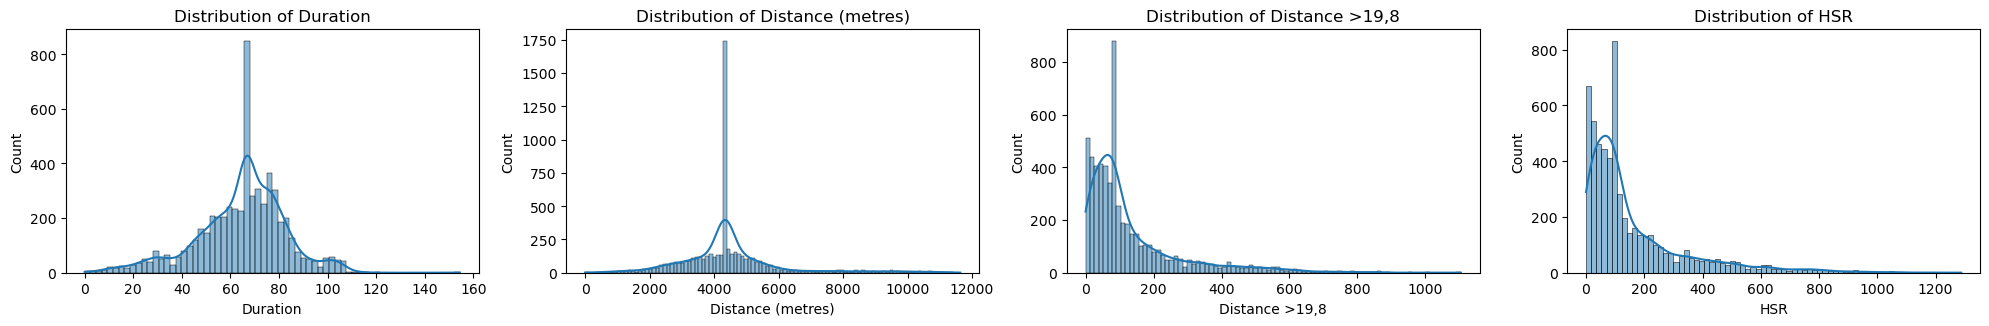

In [159]:
# 3. Visualize data distributions (Histograms and Box plots)
numerical_cols = df.select_dtypes(include=['number']).columns
plt.figure(figsize=(20, 15))
for i, col in enumerate(numerical_cols):
    plt.subplot(5, 4, i + 1)
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.tight_layout()
plt.show()

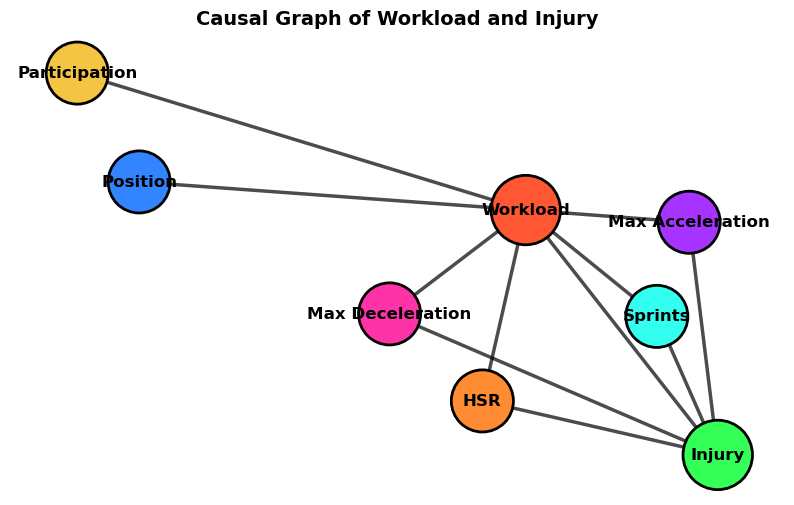

In [161]:
import networkx as nx
import matplotlib.pyplot as plt

# Initialize a directed graph
G = nx.DiGraph()

# Define nodes
nodes = {
    "Workload": {"color": "#FF5733", "size": 2500},    # Red-Orange
    "Injury": {"color": "#33FF57", "size": 2500},      # Green
    "Position": {"color": "#3385FF", "size": 2000},    # Blue
    "Participation": {"color": "#F4C542", "size": 2000}, # Yellow
    "Max Acceleration": {"color": "#A633FF", "size": 2000}, # Purple
    "Max Deceleration": {"color": "#FF33A8", "size": 2000}, # Pink
    "Sprints": {"color": "#33FFF0", "size": 2000},  # Cyan
    "HSR": {"color": "#FF8C33", "size": 2000}  # Orange
}

# Add nodes to the graph
for node, attr in nodes.items():
    G.add_node(node, **attr)

# Define edges (causal relationships)
edges = [
    ("Workload", "Injury"),
    ("Position", "Workload"),
    ("Participation", "Workload"),
    ("Max Acceleration", "Workload"),
    ("Max Deceleration", "Workload"),
    ("Sprints", "Workload"),
    ("HSR", "Workload"),
    ("Max Acceleration", "Injury"),
    ("Max Deceleration", "Injury"),
    ("Sprints", "Injury"),
    ("HSR", "Injury")
]

# Add edges to the graph
G.add_edges_from(edges)

# Draw the graph
plt.figure(figsize=(10, 6))
pos = nx.spring_layout(G, seed=42, k=0.5)  # Layout for node positioning

# Draw nodes with custom styles
node_colors = [nodes[node]["color"] for node in G.nodes()]
node_sizes = [nodes[node]["size"] for node in G.nodes()]
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes, edgecolors='black', linewidths=2)

# Draw edges
nx.draw_networkx_edges(G, pos, width=2.5, edge_color="black", arrows=True, alpha=0.7)

# Draw labels
nx.draw_networkx_labels(G, pos, font_size=12, font_weight="bold", font_color="black")

# Show the graph
plt.title("Causal Graph of Workload and Injury", fontsize=14, fontweight="bold")
plt.axis("off")
plt.show()


In [93]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select only numerical columns
numerical_columns = df.select_dtypes(include=['number'])


In [95]:
# Correlation matrix for numerical columns
correlation_matrix = numerical_columns.corr()
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

ValueError: zero-size array to reduction operation fmin which has no identity

<Figure size 1500x1000 with 0 Axes>

In [173]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from causalinference import CausalModel
from scipy.stats import ttest_ind


In [185]:
import folium
from IPython.display import display

# Coordinates of University of Sharjah Football Stadium
latitude = 25.27984
longitude = 55.47515

# Create a map centered at the University of Sharjah football stadium
m = folium.Map(location=[latitude, longitude], zoom_start=14)

# Add a marker for the stadium
folium.Marker(
    [latitude, longitude],
    popup="University of Sharjah Football Stadium",
    icon=folium.Icon(color='red', icon='info-sign')
).add_to(m)

# Add an outline or shape around the area (approximation for visual effect)
folium.PolyLine(
    locations=[
        [25.2840, 55.4700],
        [25.2840, 55.4800],
        [25.2750, 55.4800],
        [25.2750, 55.4700],
        [25.2840, 55.4700]
    ],
    color='orange',
    weight=2
).add_to(m)

# Display the map
display(m)

In [196]:
!pip install geopandas

   ---------------------------------------- 0.0/323.6 kB ? eta -:--:--
   ------- -------------------------------- 61.4/323.6 kB 1.6 MB/s eta 0:00:01
   ---------------------- ----------------- 184.3/323.6 kB 2.2 MB/s eta 0:00:01
   ----------------------------------- ---- 286.7/323.6 kB 2.2 MB/s eta 0:00:01
   ---------------------------------------- 323.6/323.6 kB 2.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/16.2 MB ? eta -:--:--
    --------------------------------------- 0.2/16.2 MB 14.1 MB/s eta 0:00:02
   - -------------------------------------- 0.5/16.2 MB 6.7 MB/s eta 0:00:03
   -- ------------------------------------- 0.9/16.2 MB 8.0 MB/s eta 0:00:02
   -- ------------------------------------- 1.0/16.2 MB 8.0 MB/s eta 0:00:02
   -- ------------------------------------- 1.0/16.2 MB 8.0 MB/s eta 0:00:02
   --- ------------------------------------ 1.3/16.2 MB 6.2 MB/s eta 0:00:03
   --- ------------------------------------ 1.5/16.2 MB 5.6 MB/s eta 0:00:03


In [198]:
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point

# Coordinates of University of Sharjah Football Stadium
sharjah_university_coords = (25.27984, 55.47515)

# Load Natural Earth Data (or local shapefile for precise UAE map)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
uae = world[world['name'] == 'United Arab Emirates']

# Create Point for University of Sharjah
sharjah_university = gpd.GeoDataFrame(geometry=[Point(sharjah_university_coords[1], sharjah_university_coords[0])], crs="EPSG:4326")

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# Map A: UAE with Sharjah Highlighted
uae.boundary.plot(ax=axes[0], color='purple')
sharjah_university.plot(ax=axes[0], color='orange', markersize=100)
axes[0].set_title("A. Map of UAE")
axes[0].set_xlabel("Longitude (E)")
axes[0].set_ylabel("Latitude (N)")
axes[0].annotate("Sharjah", (55.5, 25.4), color='black')
axes[0].grid(True, linestyle='--', linewidth=0.5)

# Map B: Zoomed-in Sharjah with University
sharjah_extent = [55.3, 55.7, 25.2, 25.4]  # Adjust for zoom level
uae.boundary.plot(ax=axes[1], color='orange')
sharjah_university.plot(ax=axes[1], color='red', markersize=200)
axes[1].set_xlim(sharjah_extent[:2])
axes[1].set_ylim(sharjah_extent[2:])
axes[1].set_title("B. Map of Sharjah")
axes[1].set_xlabel("Longitude (E)")
axes[1].set_ylabel("Latitude (N)")
axes[1].annotate("University of Sharjah", (55.48, 25.28), color='black')
axes[1].grid(True, linestyle='--', linewidth=0.5)

# Legends
fig.legend(["UAE", "Sharjah", "University of Sharjah"], loc='lower center', fontsize=10, ncol=3)

plt.tight_layout()
plt.show()

AttributeError: The geopandas.dataset has been deprecated and was removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.